In [ ]:
!nvidia-smi

!pip install -q timm scikit-learn
!pip install --upgrade timm


Sun Nov 30 20:55:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os, math, time, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

import torchvision
from torchvision import transforms
import timm
from tqdm.auto import tqdm
from sklearn.neighbors import KNeighborsClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# ---------- CONFIG: ViT-Tiny + big batch ----------
CFG = {
    "image_size": 128,          # all crops -> 128x128
    "batch_size": 256,          # if OOM -> 192 or 160
    "num_workers": 0,           # avoid multiprocessing issues
    "epochs_pretrain": 300,      # self-supervised DINO epochs
    "epochs_linear": 300,        # linear probe epochs
    "learning_rate_dino": 5e-4,
    "learning_rate_linear": 0.1,
    "weight_decay": 1e-5,
    "warmup_epochs": 2,
    "out_dim": 256,             # DINO projection dim
    "student_temp": 0.1,
    "teacher_temp": 0.04,
    "momentum_teacher": 0.996,
}
print(CFG)


Device: cuda
{'image_size': 128, 'batch_size': 256, 'num_workers': 0, 'epochs_pretrain': 100, 'epochs_linear': 150, 'learning_rate_dino': 0.0005, 'learning_rate_linear': 0.1, 'weight_decay': 1e-05, 'warmup_epochs': 2, 'out_dim': 256, 'student_temp': 0.1, 'teacher_temp': 0.04, 'momentum_teacher': 0.996}


In [ ]:
CIFAR_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR_STD  = (0.2675, 0.2565, 0.2761)

class DinoMultiCropTransform:
    """
    2 global crops + 2 local crops.
    All crops OUTPUT at size = CFG["image_size"] (128x128),
    locals differ only by scale range.
    """
    def __init__(self, size=128, n_global=2, n_local=2):
        self.n_global = n_global
        self.n_local = n_local
        self.size = size

        flip_color = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
        ])

        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
        ])

        self.global_transforms = [
            transforms.Compose([
                transforms.RandomResizedCrop(
                    size, scale=(0.4, 1.0),
                    interpolation=transforms.InterpolationMode.BICUBIC,
                ),
                flip_color,
                transforms.GaussianBlur(kernel_size=15, sigma=(0.1, 2.0)),
                normalize,
            ]),
            transforms.Compose([
                transforms.RandomResizedCrop(
                    size, scale=(0.4, 1.0),
                    interpolation=transforms.InterpolationMode.BICUBIC,
                ),
                flip_color,
                transforms.GaussianBlur(kernel_size=15, sigma=(0.1, 2.0)),
                transforms.RandomSolarize(threshold=0.5, p=0.2),
                normalize,
            ]),
        ]

        # local crops: smaller scale, but still resized to 128
        self.local_transform = transforms.Compose([
            transforms.RandomResizedCrop(
                size, scale=(0.08, 0.4),
                interpolation=transforms.InterpolationMode.BICUBIC,
            ),
            flip_color,
            transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 2.0)),
            normalize,
        ])

    def __call__(self, x):
        crops = []
        for i in range(self.n_global):
            crops.append(self.global_transforms[i](x))
        for _ in range(self.n_local):
            crops.append(self.local_transform(x))
        return crops

# ---- Datasets ----
dino_transform = DinoMultiCropTransform(size=CFG["image_size"], n_global=2, n_local=2)

train_unlabeled = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=True, transform=dino_transform
)

linear_train_transform = transforms.Compose([
    transforms.Resize(CFG["image_size"],
                     interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

linear_test_transform = transforms.Compose([
    transforms.Resize(CFG["image_size"],
                     interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

train_labeled = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=False, transform=linear_train_transform
)
test_labeled = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=False, transform=linear_test_transform
)

# ---- DataLoaders ----
pretrain_loader = DataLoader(
    train_unlabeled,
    batch_size=CFG["batch_size"],
    shuffle=True,
    num_workers=CFG["num_workers"],
    pin_memory=True,
    drop_last=True,
)

linear_train_loader = DataLoader(
    train_labeled,
    batch_size=CFG["batch_size"],
    shuffle=True,
    num_workers=CFG["num_workers"],
    pin_memory=True,
)

linear_test_loader = DataLoader(
    test_labeled,
    batch_size=CFG["batch_size"],
    shuffle=False,
    num_workers=CFG["num_workers"],
    pin_memory=True,
)

print("Unlabeled train:", len(train_unlabeled))
print("Labeled train:", len(train_labeled))
print("Labeled test :", len(test_labeled))


100%|██████████| 169M/169M [00:03<00:00, 47.7MB/s]


Unlabeled train: 50000
Labeled train: 50000
Labeled test : 10000


In [ ]:
class VitBackbone(nn.Module):
    def __init__(self, model_name="vit_tiny_patch16_224", img_size=128):
        super().__init__()
        self.vit = timm.create_model(
            model_name,
            pretrained=False,
            num_classes=0,
            img_size=img_size,
        )

    def forward(self, x):
        return self.vit(x)


class DinoHead(nn.Module):
    def __init__(self, in_dim, out_dim=256, hidden_dim=2048, bottleneck_dim=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, bottleneck_dim),
            nn.GELU(),
        )
        self.last_layer = nn.utils.weight_norm(
            nn.Linear(bottleneck_dim, out_dim, bias=False)
        )
        self.last_layer.weight_g.data.fill_(1.0)
        self.last_layer.weight_g.requires_grad = False

    def forward(self, x):
        x = self.mlp(x)
        x = F.normalize(x, dim=-1, p=2)
        return self.last_layer(x)


def build_dino_vit(out_dim=256, img_size=128):
    backbone = VitBackbone("vit_tiny_patch16_224", img_size=img_size)
    embed_dim = backbone.vit.num_features
    head = DinoHead(embed_dim, out_dim=out_dim)
    return backbone, head

student_backbone, student_head = build_dino_vit(
    out_dim=CFG["out_dim"],
    img_size=CFG["image_size"],
)
student = nn.Sequential(student_backbone, student_head).to(device)

teacher_backbone, teacher_head = build_dino_vit(
    out_dim=CFG["out_dim"],
    img_size=CFG["image_size"],
)
teacher = nn.Sequential(teacher_backbone, teacher_head).to(device)
for p in teacher.parameters():
    p.requires_grad = False

print("Student (ViT-Tiny) params (M):",
      sum(p.numel() for p in student.parameters()) / 1e6)


/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Student (ViT-Tiny) params (M): 6.484672


In [ ]:
class DINOLoss(nn.Module):
    def __init__(self, out_dim, student_temp=0.1, teacher_temp=0.04, center_momentum=0.9):
        super().__init__()
        self.student_temp = student_temp
        self.teacher_temp = teacher_temp
        self.center_momentum = center_momentum
        self.register_buffer("center", torch.zeros(1, out_dim))

    def forward(self, student_out, teacher_out):
        student_out = [s / self.student_temp for s in student_out]
        teacher_out = [(t - self.center) / self.teacher_temp for t in teacher_out]

        student_out = [F.log_softmax(s, dim=-1) for s in student_out]
        teacher_out = [F.softmax(t, dim=-1).detach() for t in teacher_out]

        total_loss, n_terms = 0.0, 0
        for t in teacher_out:
            for s in student_out:
                loss = torch.sum(-t * s, dim=-1).mean()
                total_loss += loss
                n_terms += 1
        total_loss /= n_terms

        batch_center = torch.cat(teacher_out).mean(dim=0, keepdim=True)
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)
        return total_loss

def update_teacher(student, teacher, m):
    with torch.no_grad():
        for ps, pt in zip(student.parameters(), teacher.parameters()):
            pt.data.mul_(m).add_(ps.data, alpha=1.0 - m)

dino_loss_fn = DINOLoss(
    out_dim=CFG["out_dim"],
    student_temp=CFG["student_temp"],
    teacher_temp=CFG["teacher_temp"],
).to(device)


In [ ]:
def cosine_scheduler(base_value, final_value, epochs, niter_per_epoch,
                     warmup_epochs=0, start_warmup_value=0.0):
    iters = epochs * niter_per_epoch
    warmup_iters = warmup_epochs * niter_per_epoch
    schedule = []
    for i in range(iters):
        if i < warmup_iters:
            v = start_warmup_value + i / max(1, warmup_iters) * (base_value - start_warmup_value)
        else:
            progress = (i - warmup_iters) / max(1, iters - warmup_iters)
            v = final_value + 0.5 * (base_value - final_value) * (1.0 + math.cos(math.pi * progress))
        schedule.append(v)
    return schedule

params = [p for p in student.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(
    params,
    lr=CFG["learning_rate_dino"],
    weight_decay=CFG["weight_decay"],
)

niter_per_epoch = len(pretrain_loader)
lr_schedule = cosine_scheduler(
    CFG["learning_rate_dino"],
    1e-6,
    CFG["epochs_pretrain"],
    niter_per_epoch,
    warmup_epochs=CFG["warmup_epochs"],
)

momentum_schedule = cosine_scheduler(
    CFG["momentum_teacher"],
    1.0,
    CFG["epochs_pretrain"],
    niter_per_epoch,
)

print("iters/epoch:", niter_per_epoch, "total iters:", len(lr_schedule))


iters/epoch: 195 total iters: 19500


In [ ]:
scaler = GradScaler()

def train_dino(student, teacher, dino_loss_fn, loader, optimizer,
               lr_schedule, momentum_schedule, epochs):
    it = 0
    student.train()
    teacher.eval()

    for epoch in range(epochs):
        epoch_loss = 0.0
        start = time.time()
        pbar = tqdm(loader, desc=f"[DINO] Epoch {epoch+1}/{epochs}")

        for crops, _ in pbar:
            crops = [c.to(device, non_blocking=True) for c in crops]

            for pg in optimizer.param_groups:
                pg["lr"] = lr_schedule[it]
            m = momentum_schedule[it]

            with autocast(dtype=torch.float16):
                student_out = [student(c) for c in crops]
                with torch.no_grad():
                    teacher_out = [teacher(c) for c in crops[:2]]  # 2 global crops
                loss = dino_loss_fn(student_out, teacher_out)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            update_teacher(student, teacher, m)

            epoch_loss += loss.item()
            it += 1
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        epoch_loss /= len(loader)
        print(f"Epoch {epoch+1}: loss={epoch_loss:.4f}, time={time.time()-start:.1f}s")

    return student, teacher


/tmp/ipython-input-2193493272.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [4]:
student, teacher = train_dino(
    student,
    teacher,
    dino_loss_fn,
    pretrain_loader,
    optimizer,
    lr_schedule,
    momentum_schedule,
    CFG["epochs_pretrain"],
)

os.makedirs("checkpoints", exist_ok=True)
torch.save(student_backbone.state_dict(),
           "checkpoints/dino_vit_tiny_cifar100_backbone_batch256.pth")


[DINO] Epoch 1/300:
100%|██████████████████████████████████████████████████████████ 195/195 [14:00<00:16, 4.78it/s]

Epoch   1: loss=4.9382, time=953.2s

[DINO] Epoch 2/300:
100%|██████████████████████████████████████████████████████████ 195/195 [14:00<00:16, 4.87it/s]

Epoch   2: loss=4.9240, time=936.6s

[DINO] Epoch 3/300:
100%|██████████████████████████████████████████████████████████ 195/195 [16:00<00:16, 4.70it/s]

Epoch   3: loss=4.8568, time=964.3s

[DINO] Epoch 4/300:
100%|██████████████████████████████████████████████████████████ 195/195 [14:00<00:16, 4.76it/s]

Epoch   4: loss=4.8418, time=936.2s

[DINO] Epoch 5/300:
100%|██████████████████████████████████████████████████████████ 195/195 [16:00<00:16, 4.69it/s]

Epoch   5: loss=4.7575, time=959.8s

[DINO] Epoch 6/300:
100%|██████████████████████████████████████████████████████████ 195/195 [15:00<00:16, 4.53it/s]

Epoch   6: loss=4.7523, time=946.3s

[DINO] Epoch 7/300:
100%|███████████████████████████████████████████████████

In [ ]:
backbone_linear = VitBackbone(
    "vit_tiny_patch16_224",
    img_size=CFG["image_size"],
).to(device)

state_dict = torch.load(
    "checkpoints/dino_vit_tiny_cifar100_backbone_batch256.pth",
    map_location=device,
)
backbone_linear.load_state_dict(state_dict)
backbone_linear.eval()
for p in backbone_linear.parameters():
    p.requires_grad = False

num_classes = 100

class LinearProbe(nn.Module):
    def __init__(self, backbone, in_dim, num_classes=100):
        super().__init__()
        self.backbone = backbone
        self.fc = nn.Linear(in_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            feat = self.backbone(x)
        return self.fc(feat)

embed_dim = backbone_linear.vit.num_features
linear_model = LinearProbe(backbone_linear, embed_dim, num_classes=num_classes).to(device)

criterion_ce = nn.CrossEntropyLoss()
optimizer_linear = torch.optim.SGD(
    linear_model.fc.parameters(),
    lr=CFG["learning_rate_linear"],
    momentum=0.9,
    weight_decay=0.0,
)

def evaluate_linear(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            _, preds = logits.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return 100.0 * correct / total if total > 0 else 0.0

def train_linear(model, train_loader, test_loader, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        correct = total = 0

        pbar = tqdm(train_loader, desc=f"[Linear] Epoch {epoch+1}/{epochs}")
        for imgs, labels in pbar:
            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer_linear.zero_grad()
            logits = model(imgs)
            loss = criterion_ce(logits, labels)
            loss.backward()
            optimizer_linear.step()

            total_loss += loss.item()
            _, preds = logits.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "train_acc": f"{100.0 * correct / total:.2f}%"
            })

        avg_loss = total_loss / len(train_loader)
        train_acc = 100.0 * correct / total
        test_acc = evaluate_linear(model, test_loader)
        print(f"Epoch {epoch+1}: loss={avg_loss:.4f}, train_acc={train_acc:.2f}%, test_acc={test_acc:.2f}%")


In [3]:
train_linear(
    linear_model,
    linear_train_loader,
    linear_test_loader,
    CFG["epochs_linear"],
)

[Linear] Epoch 1/300:
100%|█████████████████████████████████████████████████████ 196/196 [00:41<00:00, 4.68it/s]

Epoch   1: loss=3.9000, train_acc=10.84%, test_acc=7.88%

[Linear] Epoch 2/300:
100%|█████████████████████████████████████████████████████ 196/196 [00:46<00:00, 4.17it/s]

Epoch   2: loss=3.8911, train_acc=11.67%, test_acc=8.75%

[Linear] Epoch 3/300:
100%|█████████████████████████████████████████████████████ 196/196 [00:44<00:00, 4.44it/s]

Epoch   3: loss=3.8823, train_acc=12.49%, test_acc=9.60%

[Linear] Epoch 4/300:
100%|█████████████████████████████████████████████████████ 196/196 [00:42<00:00, 4.56it/s]

Epoch   4: loss=3.8734, train_acc=13.29%, test_acc=10.44%

[Linear] Epoch 5/300:
100%|█████████████████████████████████████████████████████ 196/196 [00:44<00:00, 4.37it/s]

Epoch   5: loss=3.8645, train_acc=14.08%, test_acc=11.26%

[Linear] Epoch 6/300:
100%|█████████████████████████████████████████████████████ 196/196 [00:49<00:00, 3.99it/s]

Epoch   6: loss=3.8557, 

In [6]:
def extract_features(backbone, loader):
    backbone.eval()
    feats, labels_all = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Extracting features"):
            imgs = imgs.to(device)
            f = backbone(imgs)
            feats.append(f.cpu())
            labels_all.append(labels)
    feats = torch.cat(feats, dim=0).numpy()
    labels_all = torch.cat(labels_all, dim=0).numpy()
    return feats, labels_all

train_feats, train_labels = extract_features(backbone_linear, linear_train_loader)
test_feats,  test_labels  = extract_features(backbone_linear, linear_test_loader)

knn = KNeighborsClassifier(n_neighbors=20, metric="cosine")
knn.fit(train_feats, train_labels)
knn_acc = knn.score(test_feats, test_labels)
print(f"k-NN accuracy on CIFAR-100 (ViT-Tiny DINO features): {knn_acc * 100:.2f}%")



Extracting features: 100%|██████████████████████████████████████████ 196/196 [00:44<00:00, 4.48it/s]
Extracting features: 100%|████████████████████████████████████████████ 40/40 [00:07<00:00, 4.62it/s]

k-NN accuracy on CIFAR-100 (ViT-Tiny DINO features): 59.34%


In [ ]:
!pip install --quiet timm

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [ ]:
# Data transforms (DINO-style ImageNet normalization)
img_transform = transforms.Compose([
    transforms.Resize(256, interpolation=Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ),
])

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225],
)

stl_train = datasets.STL10(root="./data", split="train", download=True, transform=img_transform)
stl_test  = datasets.STL10(root="./data", split="test",  download=True, transform=img_transform)

train_loader = DataLoader(stl_train, batch_size=128, shuffle=True, num_workers=2)
test_loader  = DataLoader(stl_test,  batch_size=128, shuffle=False, num_workers=2)

print("STL-10 train:", len(stl_train), "test:", len(stl_test))


100%|██████████| 2.64G/2.64G [02:12<00:00, 19.9MB/s]


STL-10 train: 5000 test: 8000


In [ ]:
def tensor_to_pil(img_tensor):
    img = inv_normalize(img_tensor.cpu())
    img = torch.clamp(img, 0, 1)
    return transforms.ToPILImage()(img)

def show_side_by_side(images, titles=None, figsize=(12,4), cmap_list=None):
    n = len(images)
    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        plt.subplot(1, n, i+1)
        if isinstance(img, torch.Tensor):
            img = img.cpu().numpy()
            if img.ndim == 3:
                img = np.transpose(img, (1,2,0))
        if cmap_list is not None and cmap_list[i] is not None:
            plt.imshow(img, cmap=cmap_list[i])
        else:
            plt.imshow(img)
        if titles is not None:
            plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:
def get_last_selfattention(model, img_batch):
    """
    img_batch: [B,3,H,W], normalized
    returns: [B, num_heads, N_tokens, N_tokens]
    """
    with torch.no_grad():
        attn = model.get_last_selfattention(img_batch)
    return attn


heads: 6 grid: 28 x 28


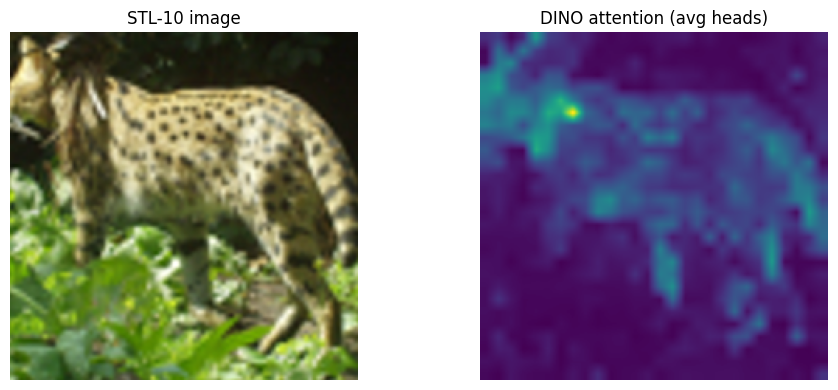

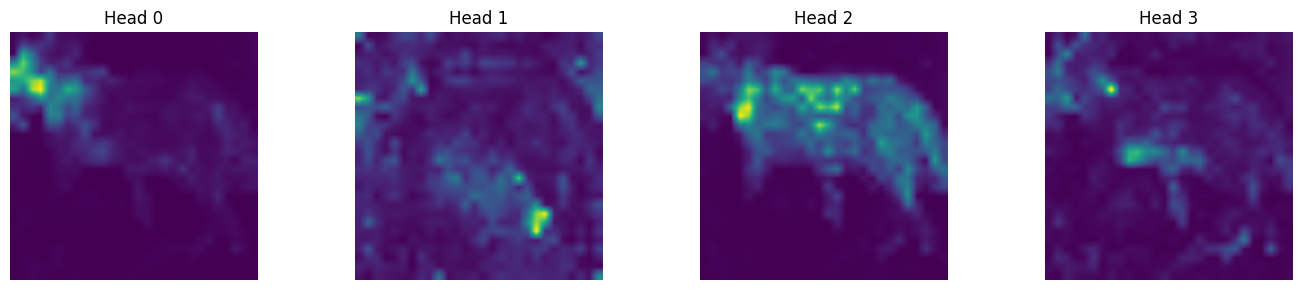

In [ ]:
def visualize_dino_attention_random():
    # sample one image
    img_tensor, label = stl_test[np.random.randint(len(stl_test))]
    x = img_tensor.unsqueeze(0).to(device)         # [1,3,224,224]

    # get attention
    attn = get_last_selfattention(model, x)        # [1, heads, N, N]
    attn = attn[0]                                 # [heads,N,N]
    num_heads, N, _ = attn.shape

    num_patches = N - 1                            # ignore CLS
    grid_size = int(math.sqrt(num_patches))        # e.g., 14x14
    print("heads:", num_heads, "grid:", grid_size, "x", grid_size)

    # CLS → patch attention
    cls_attn = attn[:, 0, 1:]                      # [heads, num_patches]
    cls_attn = cls_attn / (cls_attn.max(dim=-1, keepdim=True).values + 1e-6)

    # reshape to spatial grid
    cls_maps = cls_attn.reshape(num_heads, grid_size, grid_size)

    # upsample to image size
    H, W = x.shape[2], x.shape[3]
    cls_maps_up = F.interpolate(
        cls_maps.unsqueeze(1),
        size=(H, W),
        mode="bilinear",
        align_corners=False
    ).squeeze(1)                                   # [heads,H,W]

    # average over heads
    avg_map = cls_maps_up.mean(dim=0)
    avg_map = (avg_map - avg_map.min()) / (avg_map.max() - avg_map.min() + 1e-6)

    # original image
    img_vis = tensor_to_pil(img_tensor)

    show_side_by_side(
        [img_vis, avg_map.cpu()],
        ["STL-10 image", "DINO attention (avg heads)"],
        figsize=(10,4),
        cmap_list=[None, "viridis"]
    )

    # optional: first few heads
    heads_to_show = min(4, num_heads)
    head_imgs = []
    head_titles = []
    cmaps = []
    for h in range(heads_to_show):
        hmap = cls_maps_up[h]
        hmap = (hmap - hmap.min()) / (hmap.max() - hmap.min() + 1e-6)
        head_imgs.append(hmap.cpu())
        head_titles.append(f"Head {h}")
        cmaps.append("viridis")

    show_side_by_side(
        head_imgs,
        head_titles,
        figsize=(14,3),
        cmap_list=cmaps
    )

visualize_dino_attention_random()


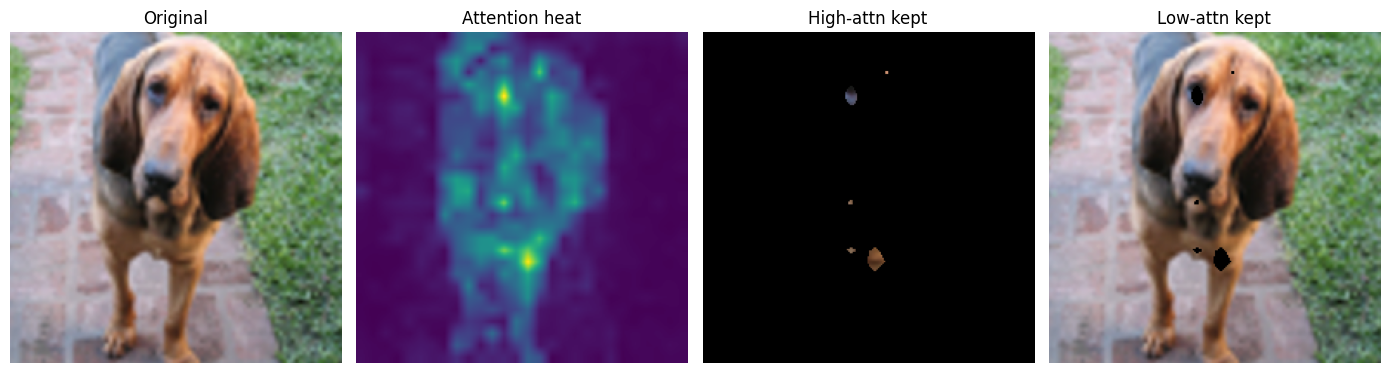

In [ ]:
def attention_to_mask(attn_map, threshold=0.7):
    """
    attn_map: [H,W] torch tensor in [0,1]
    returns binary mask [H,W] in {0,1}
    """
    attn_np = attn_map.cpu().numpy()
    mask = (attn_np >= threshold).astype(np.float32)
    return mask

def visualize_attention_mask_random(threshold=0.7):
    img_tensor, label = stl_test[np.random.randint(len(stl_test))]
    x = img_tensor.unsqueeze(0).to(device)

    attn = get_last_selfattention(model, x)[0]
    num_heads, N, _ = attn.shape
    num_patches = N - 1
    grid = int(math.sqrt(num_patches))

    cls_attn = attn[:, 0, 1:]
    cls_attn = cls_attn / (cls_attn.max(dim=-1, keepdim=True).values + 1e-6)
    cls_maps = cls_attn.reshape(num_heads, grid, grid)

    H, W = x.shape[2], x.shape[3]
    cls_maps_up = F.interpolate(
        cls_maps.unsqueeze(1),
        size=(H, W),
        mode="bilinear",
        align_corners=False
    ).squeeze(1)

    avg_map = cls_maps_up.mean(dim=0)
    avg_map = (avg_map - avg_map.min()) / (avg_map.max() - avg_map.min() + 1e-6)

    mask_high = attention_to_mask(avg_map, threshold=threshold)
    mask_low  = 1.0 - mask_high

    img_denorm = inv_normalize(img_tensor).clamp(0,1).cpu().numpy()
    mask_high_3c = np.stack([mask_high]*3, axis=0)
    mask_low_3c  = np.stack([mask_low]*3, axis=0)

    img_high = img_denorm * mask_high_3c
    img_low  = img_denorm * mask_low_3c

    img_pil = tensor_to_pil(img_tensor)
    img_high_pil = transforms.ToPILImage()(torch.from_numpy(img_high))
    img_low_pil  = transforms.ToPILImage()(torch.from_numpy(img_low))

    show_side_by_side(
        [img_pil, avg_map.cpu(), img_high_pil, img_low_pil],
        ["Original", "Attention heat", "High-attn kept", "Low-attn kept"],
        figsize=(14,4),
        cmap_list=[None, "viridis", None, None]
    )

visualize_attention_mask_random(threshold=0.7)


In [ ]:
@torch.no_grad()
def dino_features(model, x, layer_index=-1, use_cls=True):
    """
    Get features from an intermediate layer of DINO ViT.
    x: [B,3,H,W] normalized
    Returns: [B, C] (CLS or pooled patch tokens)
    """
    # returns list of layer outputs; we take the last by default
    feats = model.get_intermediate_layers(x, n=1)[0]   # [B, N, C]
    if use_cls:
        return feats[:, 0]                             # CLS token [B,C]
    else:
        return feats[:, 1:].mean(dim=1)                # mean over patches


In [9]:

from sklearn.neighbors import KNeighborsClassifier

# 1) Extract train features
train_feats = []
train_labels = []

for imgs, labels in DataLoader(stl_train, batch_size=128, shuffle=False):
    imgs = imgs.to(device)
    f = dino_features(model, imgs)   # [B, C]
    train_feats.append(f.cpu())
    train_labels.append(labels)

train_feats = torch.cat(train_feats, dim=0).numpy()
train_labels = torch.cat(train_labels, dim=0).numpy()
print("Train features:", train_feats.shape)

# 2) Fit k-NN
knn = KNeighborsClassifier(n_neighbors=20, metric="cosine")
knn.fit(train_feats, train_labels)

# 3) Extract test features + evaluate
test_feats = []
test_labels = []

for imgs, labels in test_loader:
    imgs = imgs.to(device)
    f = dino_features(model, imgs)
    test_feats.append(f.cpu())
    test_labels.append(labels)

test_feats = torch.cat(test_feats, dim=0).numpy()
test_labels = torch.cat(test_labels, dim=0).numpy()

acc = (knn.predict(test_feats) == test_labels).mean()
print(f"k-NN accuracy on STL-10 using DINO embeddings: {acc*100:.2f}%")

Train features: (5000, 384)
k-NN accuracy on STL-10 using DINO embeddings: 63.40%


In [ ]:
# Dimension of DINO features
with torch.no_grad():
    sample_x, _ = next(iter(train_loader))
    sample_x = sample_x.to(device)
    feat_dim = dino_features(model, sample_x).shape[1]



In [ ]:
linear_head = nn.Linear(feat_dim, 10).to(device)  # STL-10 has 10 classes
optimizer = torch.optim.Adam(linear_head.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


In [8]:
def train_linear_probe(epochs=2):
    model.eval()
    linear_head.train()

    for ep in range(epochs):
        total_loss = 0
        total_correct = 0
        total_count = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            with torch.no_grad():
                feats = dino_features(model, imgs)  # [B,C]

            logits = linear_head(feats)
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(1)
            total_correct += (preds == labels).sum().item()
            total_count += imgs.size(0)

        print(f"Epoch {ep+1}/{epochs} | Loss {total_loss/total_count:.4f} | "
              f"Train Acc {total_correct/total_count*100:.2f}%")

def eval_linear_probe():
    model.eval()
    linear_head.eval()
    total_correct = 0
    total_count = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            feats = dino_features(model, imgs)
            logits = linear_head(feats)
            preds = logits.argmax(1)
            total_correct += (preds == labels).sum().item()
            total_count += imgs.size(0)
    print(f"Linear probe test accuracy: {total_correct/total_count*100:.2f}%")

train_linear_probe(epochs=2)
eval_linear_probe()

Epoch 1/2 | Loss 1.9824 | Train Acc 52.73%
Epoch 2/2 | Loss 1.2147 | Train Acc 63.85%

Linear probe test accuracy: 64.12%



In [ ]:
# store train set features for retrieval
train_feats = []
train_labels = []
train_imgs_raw = []   # for visualization

for img_tensor, label in stl_train:
    x = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        feat = dino_features(model, x)[0].cpu()
    train_feats.append(feat)
    train_labels.append(label)
    train_imgs_raw.append(img_tensor)  # still normalized

train_feats = torch.stack(train_feats, dim=0)  # [N,C]
train_labels = torch.tensor(train_labels)
print("Train feats:", train_feats.shape)


Train feats: torch.Size([5000, 384])


Query label: 6


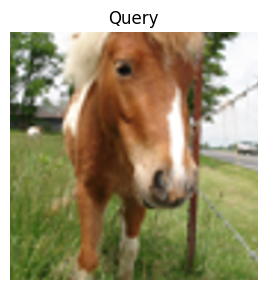

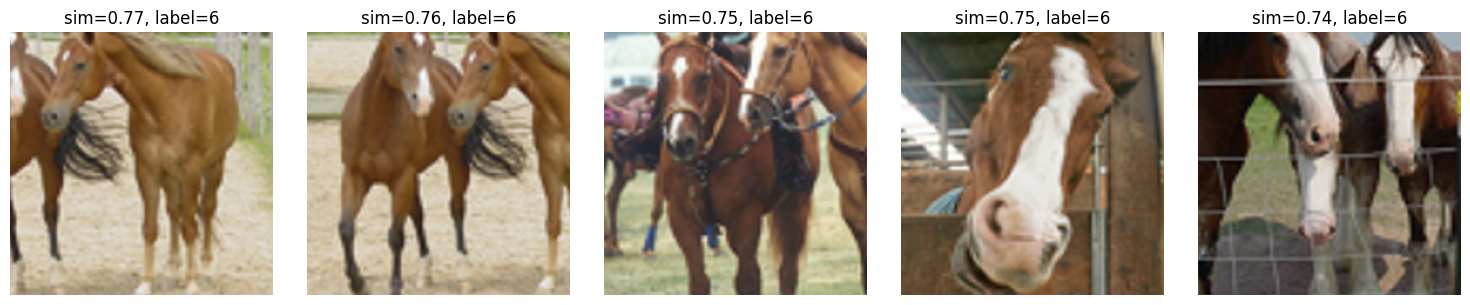

In [ ]:
@torch.no_grad()
def retrieve_similar_images(query_img_tensor, k=5):
    x = query_img_tensor.unsqueeze(0).to(device)
    q_feat = dino_features(model, x)[0].cpu()        # [C]

    # cosine similarity against all train features
    feats_norm = F.normalize(train_feats, dim=1)
    q_norm = F.normalize(q_feat.unsqueeze(0), dim=1)
    sims = (feats_norm @ q_norm.T).squeeze(1)        # [N]

    topk_vals, topk_idx = torch.topk(sims, k=k)
    return topk_idx, topk_vals

def visualize_retrieval_example():
    # pick random test image as query
    q_tensor, q_label = stl_test[np.random.randint(len(stl_test))]
    idxs, sims = retrieve_similar_images(q_tensor, k=5)

    q_pil = tensor_to_pil(q_tensor)

    retrieved_imgs = [tensor_to_pil(train_imgs_raw[i]) for i in idxs]
    titles = [f"sim={sims[i].item():.2f}, label={train_labels[idxs[i]].item()}"
              for i in range(len(idxs))]

    print("Query label:", q_label)
    show_side_by_side([q_pil], ["Query"], figsize=(3,3))
    show_side_by_side(retrieved_imgs, titles, figsize=(15,3))

visualize_retrieval_example()


In [7]:
from collections import defaultdict

def make_few_shot_subset(dataset, shots_per_class=5):
    class_to_imgs = defaultdict(list)
    for img, label in dataset:
        class_to_imgs[label].append((img, label))

    few_imgs = []
    few_labels = []
    for lbl, items in class_to_imgs.items():
        for img, lab in items[:shots_per_class]:
            few_imgs.append(img)
            few_labels.append(lab)

    return few_imgs, few_labels

few_imgs, few_labels = make_few_shot_subset(stl_train, shots_per_class=5)
print("Few-shot subset size:", len(few_imgs))

# extract features
few_feats = []
for img, lab in zip(few_imgs, few_labels):
    x = img.unsqueeze(0).to(device)
    with torch.no_grad():
        feat = dino_features(model, x)[0].cpu()
    few_feats.append(feat)

few_feats = torch.stack(few_feats, dim=0).numpy()
few_labels = np.array(few_labels)

knn_few = KNeighborsClassifier(n_neighbors=1, metric="cosine")
knn_few.fit(few_feats, few_labels)

# evaluate on full test set
test_feats = []
test_labels = []

for imgs, labels in test_loader:
    imgs = imgs.to(device)
    with torch.no_grad():
        f = dino_features(model, imgs).cpu()
    test_feats.append(f)
    test_labels.append(labels)

test_feats = torch.cat(test_feats, dim=0).numpy()
test_labels = torch.cat(test_labels, dim=0).numpy()

acc_few = (knn_few.predict(test_feats) == test_labels).mean()
print(f"Few-shot 5-shot 1-NN accuracy: {acc_few*100:.2f}%")

Few-shot subset size: 50
Few-shot 5-shot 1-NN accuracy: 56.97%
